# Convergencia Tipo X

In [2]:
import numpy as np
import pandas as pd

import sys, os

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns

import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
from pyfrechet.metric_spaces import MetricData, LogCholesky, spd_to_log_chol, log_chol_to_spd
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from sklearn.model_selection import train_test_split
from pyfrechet.metric_spaces import MetricData, LogEuclidean, CustomAffineInvariant, CustomLogEuclidean, AffineInvariant, LogCholesky, log_chol_to_spd, spd_to_log_chol

from scipy.special import digamma
from scipy.stats import wishart
from typing import Union
from pyfrechet.regression.trees import Tree
from pyfrechet.metric_spaces import MetricData, Wasserstein1D
from pyfrechet.metric_spaces import wasserstein_1d as ws
from scipy import stats 

python(2630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
INFO: Using numpy backend


## Functions

In [3]:
GRID = np.linspace(0.01, 0.99, 100)
STD_NORMAL_Q = stats.norm.ppf(GRID)


def sample_linear_transport(x, sig=1, gam=0.5):
    gam = np.random.gamma(0.5, 0.5)
    sig = np.random.exponential(0.5)
    Q0 = gam - np.log(1 + x) + (sig + x**2) * STD_NORMAL_Q
    return Q0 
    
def gen_data(N):
    # We know the values of Q in a grid, and we interpolate to estimate the values of Q in the new grid
    x = np.repeat(0, N)
    y = np.array([ sample_linear_transport(x[i]) for i in range(N)])
    
    return {'x': x, 'y': y}

In [4]:
# Obtain coverage results dataframe from the results files
def coverage_results() -> pd.DataFrame:
    coverage_df=pd.DataFrame(columns=['sample_index', 'y_train_data', 'train_predictions', 'OOB_quantile', 'OOB_errors', 'forest'])
    for file in os.listdir(os.path.join(os.getcwd(), 'wass_results')):
        if file.endswith('.npy'):
            infile=open(os.path.join(os.getcwd(), 'wass_results/'+file), 'rb')
            result=np.load(infile, allow_pickle=True).item()
            infile.close()
            coverage_df=pd.concat([coverage_df, 
                                    pd.DataFrame({  'sample_index': int(file.split('_')[1][4:]),
                                                    'y_train_data': [result['y_train_data']],
                                                    'train_predictions': [result['train_predictions']],
                                                    'forest': [result['forest']],
                                                }, index=pd.RangeIndex(0,1))],
                                    ignore_index=True)
        

    coverage_df['sample_index']=coverage_df['sample_index'].astype('category')
    #coverage_df['y_test_data'] = coverage_df['y_test_data'].apply(lambda x: x.data)
    #coverage_df['test_predictions'] = coverage_df['test_predictions'].apply(lambda x: x.data)
    return coverage_df

coverage_df=coverage_results()
# coverage_df_LC=coverage_results(dist = 'LC', dfs=dfs)
# coverage_df_LE=coverage_results(dist = 'LE', dfs=dfs)
# 
# print(coverage_df.info())
# print(coverage_df_LC.info())
# print(coverage_df_LE.info())

KeyboardInterrupt: 

In [1]:
coverage_df['IV_coverage'] = [[0, 0, 0] for _ in range(len(coverage_df))]

NameError: name 'coverage_df' is not defined

In [7]:
# Obtain Type IV coverages for affine invariant distance
np.random.seed(1000)
M = Wasserstein1D()
MC = 1000

for i, ln in coverage_df.iterrows():
        #Generate observations to estimate the probability
    new_t, new_y = gen_data(MC).values()
    new_y = MetricData(M, np.array(new_y))

    new_pred = ln['forest'].predict(new_t.reshape(-1,1))

    coverage_df.at[i, 'IV_coverage'] = np.sum(M.d(new_pred, new_y).reshape(-1,1) <= np.tile(ln['OOB_quantile'], (MC, 1)), axis = 0) / MC

# Boxplots

C:\Users\Diego\AppData\Local\Temp\ipykernel_32176\1248308578.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels = ['0.01', '0.05', '0.1'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False)


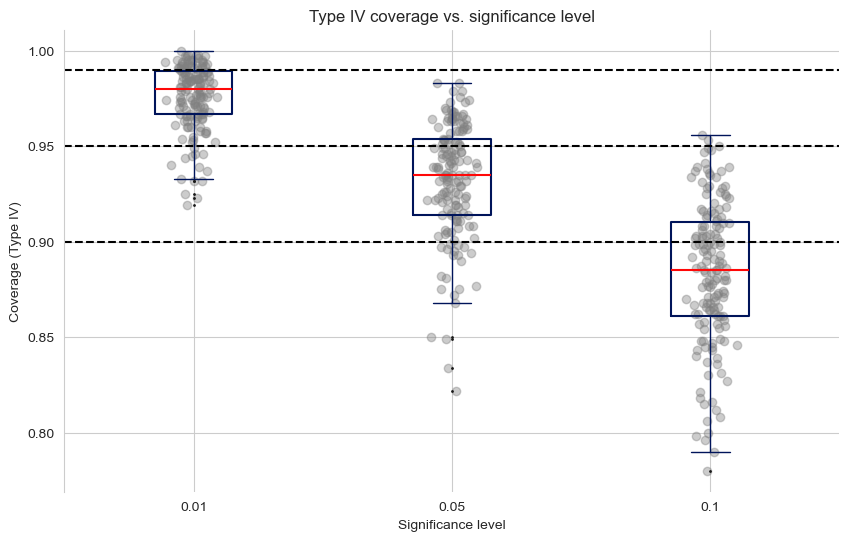

In [40]:
# Plot coverages vs. training sample size

# Only for AI

##### Set style options here #####

boxprops = dict(linestyle='-', linewidth=1.5, color='#00145A')
flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
whiskerprops = dict(color='#00145A')
capprops = dict(color='#00145A')
medianprops = dict(linewidth=1.5, linestyle='-', color='#ff0808')

first_elements = [x[0] for x in coverage_df['IV_coverage'].values]
second_elements = [x[1] for x in coverage_df['IV_coverage'].values]
third_elements = [x[2] for x in coverage_df['IV_coverage'].values]

boxplot_data = pd.DataFrame({
    '0_01': first_elements,
    '0_05': second_elements,
    '0_1': third_elements
})
sns.set_style("whitegrid")  # "white","dark","darkgrid","ticks"
plt.figure(facecolor="white", figsize=(10, 6))
plt.boxplot(boxplot_data, labels = ['0.01', '0.05', '0.1'], notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,showmeans=False) 
vals, names, xs = [],[],[]
for i, col in enumerate(boxplot_data.columns):
    vals.append(boxplot_data[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, boxplot_data[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4, color = 'gray')
sns.despine(bottom=True) # removes right and top axis lines

#plt.legend(bbox_to_anchor=(0.31, 1.06), loc=2, borderaxespad=0., framealpha=1, facecolor ='white', frameon=True)
plt.title(f'Type IV coverage vs. significance level')
plt.xlabel('Significance level')
plt.ylabel('Coverage (Type IV)')
plt.axhline(y= 1 - 0.01, color='black', linestyle='dashed')
plt.axhline(y= 1 - 0.05, color='black', linestyle='dashed')
plt.axhline(y= 1 - 0.1, color='black', linestyle='dashed')
plt.style.use('grayscale')
plt.show()

In [44]:
import pickle
import os
files = [
'WASS_Samp547.pkl',
'WASS_Samp590.pkl',
'WASS_Samp235.pkl',
'WASS_Samp209.pkl',
'WASS_Samp221.pkl',
'WASS_Samp553.pkl',
'WASS_Samp786.pkl',
'WASS_Samp792.pkl',
'WASS_Samp962.pkl'
]

samples = []
for file in files:

    with open(os.path.join(os.path.join(os.getcwd()), 'wass_data/' + file), 'rb') as f:
        sample = pickle.load(f)
        samples.append(sample)

# Now `samples` contains the data from all the files

In [63]:
samples[1]['y']
sample = samples[0]

IndexError: list index out of range

In [62]:
X=np.c_[sample['x']]
sign_level = np.array([0.01, 0.05, 0.1])
y = np.array(sample['y'])

base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=None,
            min_split_size=1)

forest = BaggedRegressor(estimator=base,
                            n_estimators = 200,
                            bootstrap_fraction=1,
                            bootstrap_replace=True,
                            n_jobs=1)


M = Wasserstein1D()
y = MetricData(M, y)

forest.fit(X, y)

oob_errors = forest.oob_errors()

Dalpha = np.percentile(oob_errors, (1-sign_level)*100)

results = { 'x_train_data': X,
            'y_train_data': y.data,
            'train_predictions': forest.predict(X).data,
            'OOB_quantile' : Dalpha,
            'forest': forest,
            }

In [41]:
# Check for NaNs in the 'y' key of the first sample
import numpy as np
if np.isnan(samples[0]['y']).any():
    print("Missing values found in 'y'")
else:
    print("No missing values in 'y'")


No missing values in 'y'
